# MNIST dataset
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)) and 
Mikkel Vilstrup ([mvilstrup](https://github.com/MVilstrup)).
</span>

In this notebook we will guide you through building a neural network classifier for the (in)famous MNIST dataset.
MNIST is a dataset that is often used for benchmarking, consisting of 70.000 image-label paris of handwritten digits from 0-9.
During the notebook we have provided a program skeleton and severalt tips to help guid you through it.
Further more the task is quite similar to what you did in the previous notebook, so you should reffer to it in order to remind yourself about the implementation.

Along the way you will also learn about 
* selecting nonlinearity, and
* stochastic gradient descent with mini-batches.

We will implement a dense feedforward neural network (just like before).
In this setting we represent each image as a vector, instead of a 2D map.
We therefore lose the spatial information of the images.
The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance.
This task is therefore called the _permutation invariant_ MNIST.
Obviously this throws away a lot of structure in the data that could have been used.
Later we will see how spatial information can be included, by using the convolutional neural network architecture.


## Implementation Rules

In this exercise we want you to get some experience with setting up training for yourself, and we therefore want you to implement the training loop yourself.
You are therefore **NOT** allowed to use the `keras.models.Sequential.fit` function.
The `Sequential` model, or built in layers, such as `keras.layers.Dense` are allowed, as long as you define the training ops and training loop yourself.
(If are having problems using `keras.layers` have a look at the [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) tutorial).


In [207]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## The MNIST dataset
The 70,000 images-label pairs are split into a 
* 55,000 images training set, 
* 5,000 images validation set and 
* 10,000 images test set.

The images are 28x28 pixels, where each pixel represents the light intensity normalised value between 0-1 (0=black, 1=white).
The number of features is therefore 28x28=784.

First let's load the MNIST dataset and plot a few examples. TensorFlow has a [convenient MNIST interface](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) that we will use to download and manage the data.

In [208]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


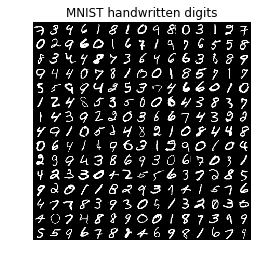

In [209]:
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()


## Creating the graph

#### <span style="color:red"> EXE 1) Defining the network
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Define two layers. Remember to give them proper names.
    * Try some different nonlinearities, and compare their performance
* The non-linearity of the output layer should be softmax ([tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax))


In [210]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float32, [None, num_classes], name='yPlaceholder')
# Depending on your implementation you might need to cast y_pl differently

## Define the model

### YOUR CODE HERE ###

n_hidden1 = 100

weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

with tf.variable_scope('model'): 

    ### Create layer 1
    with tf.variable_scope('layer1'): 

        W_1 = tf.get_variable('W_1', [num_features, n_hidden1], 
                              initializer=weight_initializer)
        b_1 = tf.get_variable('b_1', [n_hidden1],
                              initializer=tf.constant_initializer(0.0))

        with tf.variable_scope('output1'):

            l_1 = tf.matmul(x_pl, W_1) + b_1
            l_1 = tf.nn.relu(l_1)

    ### Create layer 2
    with tf.variable_scope('layer2'): 

        W_2 = tf.get_variable('W_2', [n_hidden1, num_classes],
                              initializer=weight_initializer)
        b_2 = tf.get_variable('b_2', [num_classes], 
                              initializer=tf.constant_initializer(0.0))

        with tf.variable_scope('output2'):

            l_2 = tf.matmul(l_1, W_2) + b_2

y = tf.nn.softmax(l_2) # <-- CHANGE!

#### <span style="color:red"> EXE 2) Defining the training operations.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Cross_entropy loss
* An optimizer and training op
* An op computing the accuracy

In [211]:
### Implement training ops

### YOUR CODE HERE ###

# 1) Define cross entropy loss

with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])

    # Average over samples
    # Averaging makes the loss invariant to batch size, which is very nice.
    cross_entropy = tf.reduce_mean(cross_entropy)

# 2) Define the training op    
with tf.variable_scope('trainOP'):
    # Defining our optimizer
    optimizer = tf.train.AdamOptimizer(1e-4)

    # Computing our gradients
    grads_and_vars = optimizer.compute_gradients(cross_entropy)

    # Applying the gradients
    train_op = optimizer.apply_gradients(grads_and_vars)    
    
# 3) Define accuracy op

with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [212]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

### Stochastic gradient descent with mini-batches

In the last notebook we used the entire dataset to compute every parameter update.
For large datasets this is very costly and inefficient.
Instead we can compute the gradient on only a small subset of the data, a *mini-batches*, and use it to update the parameters.
Bath size varies a lot depending on application but between 8-256 is common.
Bigger is not allways better.
With smaller mini-batch size you get more updates and your model might converge faster.
Also small batchsizes uses less memory -> freeing up memory so you train a model with more parameters.

#### <span style="color:red"> EXE 3) Testing the forward pass
</span>

Before building the training loop lets ensure that the forward pass works.

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* define the `feed_dict`
* pass `x` through the network using `sess.run`

In [213]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x_tr, y_tr = mnist_data.train.next_batch(batch_size)

# Restricting memory usage, TensorFlow is greedy and will use all memory otherwise
#gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    ### YOUR CODE HERE ###
    feed_dict = {x_pl: x_tr}
    fetches = y
    y_pred = sess.run(fetches, feed_dict)    
    
    #feed_dict_train = {x_pl: x_tr, y_pl: y_tr}
    #fetches_train = [train_op, cross_entropy, accuracy]    
    #y_pred = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)

assert y_pred.shape == y_tr.shape, "ERROR the output shape is not as expected! Output shape should be " + str(y_tr.shape) + "but was" + str(y_pred.shape)

# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches.
Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples.
The paramters are updated after each mini batch.
Networks converges much faster using minibatches because the paramters are updated more often.



#### <span style="color:red"> EXE 4) Building the training loop.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Perform the training operation
* Collect training statistics
* [Optional] Monitor training in TensorBoard.

In [257]:
max_epochs = 3000
batch_size = 64

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())

        for e in range(max_epochs):
        
        #while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x_tr, y_tr = mnist_data.train.next_batch(batch_size)
            
            ### YOUR CODE HERE ###
            # 1) Run the train op
            
            feed_dict_train = {x_pl: x_tr, y_pl: y_tr}            
            fetches_train = [train_op, cross_entropy, accuracy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
      
            # 2) Compute train_cost, val_cost, train_acc, val_acc
        
            # storing cross entropy (second fetch argument, so index=1)
            train_cost += [res[1]]
            train_acc += [res[2]]              
        
            feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}

            # deciding which parts to fetch
            fetches_valid = [cross_entropy, accuracy]          
            
            # running the validation
            res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            val_cost += [res[0]]
            val_acc += [res[1]]            
                      
            # 3) Print training summaries
            
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                      %(e, train_cost[-1],val_cost[-1],val_acc[-1]))
                
        # Retrieve the weights
        weights1 = W_1.eval()
        biases1 = b_1.eval()
        
        weights2 = W_2.eval()
        biases2 = b_2.eval()        
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')

Epoch 0, Train Cost: 2.439	Val Cost: 2.489	 Val acc: 0.065
Epoch 100, Train Cost: 1.884	Val Cost: 1.893	 Val acc: 0.433
Epoch 200, Train Cost: 1.444	Val Cost: 1.435	 Val acc: 0.699
Epoch 300, Train Cost: 1.147	Val Cost: 1.094	 Val acc: 0.785
Epoch 400, Train Cost: 0.956	Val Cost: 0.865	 Val acc: 0.818
Epoch 500, Train Cost: 0.729	Val Cost: 0.719	 Val acc: 0.839
Epoch 600, Train Cost: 0.616	Val Cost: 0.624	 Val acc: 0.852
Epoch 700, Train Cost: 0.532	Val Cost: 0.557	 Val acc: 0.863
Epoch 800, Train Cost: 0.575	Val Cost: 0.508	 Val acc: 0.875
Epoch 900, Train Cost: 0.514	Val Cost: 0.472	 Val acc: 0.885
Epoch 1000, Train Cost: 0.414	Val Cost: 0.443	 Val acc: 0.889
Epoch 1100, Train Cost: 0.457	Val Cost: 0.420	 Val acc: 0.893
Epoch 1200, Train Cost: 0.469	Val Cost: 0.400	 Val acc: 0.898
Epoch 1300, Train Cost: 0.367	Val Cost: 0.384	 Val acc: 0.903
Epoch 1400, Train Cost: 0.322	Val Cost: 0.370	 Val acc: 0.904
Epoch 1500, Train Cost: 0.380	Val Cost: 0.358	 Val acc: 0.909
Epoch 1600, Train Co

#### <span style="color:red"> EXE 5) Building the training loop.
</span>

You should have saved training statistics in `train_cost`, `val_cost`, `train_acc`, `val_acc`.
1. Plot train and validation loss as a function of time
2. Plot train and validation accuracy as a function of time
3. Select some random validation images, visualize them, and examine the output of the network.
    * How well does it do? When does it make mistakes?


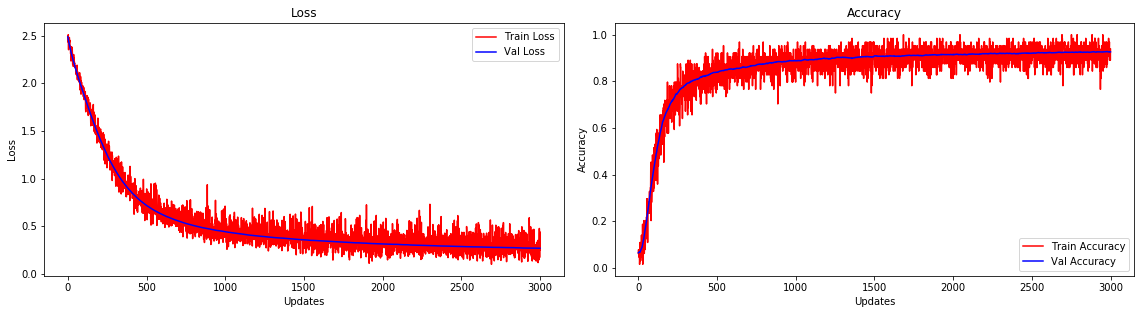

In [258]:
### YOUR CODE HERE ###
# 1) Plot train and validation loss as a function of time
# 2) Plot train and validation accuracy as a function of time
# 3) Select some random validation images, visualize them, and examine the output of the network.

## Plotting
fig = plt.figure(figsize=(16,12))
epoch = np.arange(len(train_cost))
fig.add_subplot(325)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

fig.add_subplot(326)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


# Closing Remarks

You have now seen several different ways in which feed forward neural networks can be created.
There is no "right" way to define a neural network.
Ideally you should be able to understand how to implement everything at a low-level, and use high-level APIs to reduce human error and speedup development.
There are numerous frameworks which takes care the fundamental concepts are implemented correctly.
In this class we will mostly use Tensorflow and show Keras implementations here and there.
There are however alternatives that each have their strenghts and weaknesses: 
- [Pytorch](http://pytorch.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [CNTK](https://github.com/Microsoft/CNTK)
- [Chainer](https://github.com/chainer/chainer)
- ... etc.

There is no framework that is "better" than the others.
However, each has their particular focus.
Keras tries to be the easiest to use and takes the most "High-level" approach to Deep Learning.
This might be useful at times, however, at others you might want to have more flexibility than such a High-level framework can provide. 

As you will see, FFNs are just one of many types of architectures and from here we will take a look at the extremely useful alternative called Convolutional Neural Networks. 